# Machine Learning Nanodegree - Capstone Project

## Who is in the photo?

The proposal of this project is to build a model that allow to recognize persons in the image using Deep Learning.

### Step 0: Import dataset

In [33]:
%matplotlib inline

from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

def load_face_dataset(path):
    data = load_files(path)
    general_targets = data['target']
    face_files = np.array(data['filenames'])
    face_targets = np_utils.to_categorical(np.array(data['target']), 16)
    return face_files, face_targets

train_files, train_targets = load_face_dataset('faces2/train')
valid_files, valid_targets = load_face_dataset('faces2/valid')
test_files, test_targets = load_face_dataset('faces2/test')

person_names = [item[12:-1] for item in sorted(glob("faces2/train/*/"))]


print('There are %d total person names.' % len(person_names))
print('There are %s total face images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training face images.' % len(train_files))
print('There are %d validation face images.' % len(valid_files))
print('There are %d test face images.'% len(test_files))

There are 16 total person names.
There are 2803 total face images.

There are 2245 training face images.
There are 277 validation face images.
There are 281 test face images.


#### Loading image data into array

In [2]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path, target_size=(100,100)):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=target_size)
    x = image.img_to_array(img)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths, target_size=(100,100)):
    list_of_tensors = [path_to_tensor(img_path, target_size) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

#### Loading Image for baseline model

In [34]:
import cv2
from scipy.misc import imread
from scipy.misc import imresize

def load_image_from(img_path):    
   img = cv2.imread(img_path)
#    img = cv2.resize(img,(100,100))
   return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def load_images_from(img_paths):
    images = [load_image_from(path) for path in tqdm(img_paths)]
    return np.array(images)

#### Load tensors to train, test and validations

In [4]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255



100%|██████████| 281/281 [00:00<00:00, 1711.21it/s]


#### Load image to train, test and validations of a baseline model

In [6]:
# base model
base_train_images = load_images_from(train_files).astype('float32')/255
base_test_images = load_images_from(test_files).astype('float32')/255
base_valid_images = load_images_from(valid_files).astype('float32')/255

NameError: name 'load_images_from' is not defined

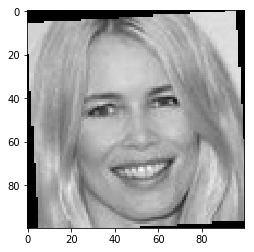

In [6]:
import matplotlib.pyplot as plt                        

img = base_train_images[0]
plt.imshow(img,cmap='gray')
plt.show()

### Step 1:  Train a base line model

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from time import time


#### Create a lookup table

In [8]:
def create_lookup_table(targets):
    lookup = []
    for target in targets:
        index = np.where(target==1)[0]
        lookup.append(index[0])
    return np.array(lookup)


In [9]:
base_train_targets = create_lookup_table(train_targets)
base_test_targets = create_lookup_table(test_targets)
base_valid_targets = create_lookup_table(valid_targets)


#### Creating a function to execute a PCA

In [10]:
def execute_pca(train, test, n_components):
    print("Extracting the top %d eigenfaces from %d faces"
        % (n_components, train.shape[0]))
    t0 = time()
    pca = PCA(n_components=n_components, svd_solver='randomized',
            whiten=True).fit(train)

    print("done in %0.3fs" % (time() - t0))
    # eigenfaces = pca.components_.reshape((n_components, h, w))
    print("Projecting the input data on the eigenfaces orthonormal basis")
    t0 = time()
    X_train_pca = pca.transform(train)
    X_test_pca = pca.transform(test)
    print("done in %0.3fs" % (time() - t0))
    return X_train_pca, X_test_pca


#### Creating a function to training a model 

In [12]:
def apply_svm(X_train, y_train):
    # Train a SVM classification model
    print("Fitting the classifier to the training set")
#     param_grid = {
#     'C': [1, 5, 10, 50, 100],
#     'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
#     }
#     param_grid = {
#         'C': [1e3, 5e3, 1e4, 5e4, 1e5],
#         'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
#     }
    
    param_grid = [
        {'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],'C': [1, 10, 100, 1000]},
        {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}
    ]

    clf = GridSearchCV(SVC(kernel='rbf',class_weight='balanced'), param_grid)
    clf = clf.fit(X_train, y_train)
    print("Best estimator found by grid search:")
    print(clf.best_estimator_)
    return clf


### Exploring and Normalize the dataset

#### Create a function to visualize the dataset

In [13]:
def image_grid(D,H,W,cols=10,scale=1, rows_count=None):
    """ display a grid of images
        H,W: Height and width of the images
        cols: number of columns = number of images in each row
        scale: 1 to fill screen
    """
    n = np.shape(D)[0]
    if rows_count:
        n = rows_count 
    rows = int(math.ceil((n+0.0)/cols))
    fig = plt.figure(1,figsize=[scale*20.0/H*W,scale*20.0/cols*rows],dpi=300)
    for i in range(n):
        plt.subplot(rows,cols,i+1)
        fig=plt.imshow(np.reshape(D[i,:],[H,W]), cmap = plt.get_cmap("gray"))
        plt.axis('off')

#### Transform the image Matrix in a vector to use in PCA analysis

In [14]:
from PIL import Image       
import glob
import math

def image_to_vector(image_paths, H,W):
    image_count = len(image_paths)
    # and columns as pixels
    arr = np.zeros([image_count,H*W])
    for i in range(image_count):
        im = Image.open(image_paths[i]).convert("L")
        arr[i,:] = np.reshape(np.asarray(im),[1,H*W])
    return arr

In [15]:
def extract_mean(images):
    return np.mean(images, axis=0)


In [16]:
def centralize(images, mean_image, H,W):
    im_number = len(images)
    
    arr_norm = np.zeros([im_number, H*W])
    arr_norm = images - mean_image
    return arr_norm

#### Show some image examples

shape:  (100, 100)


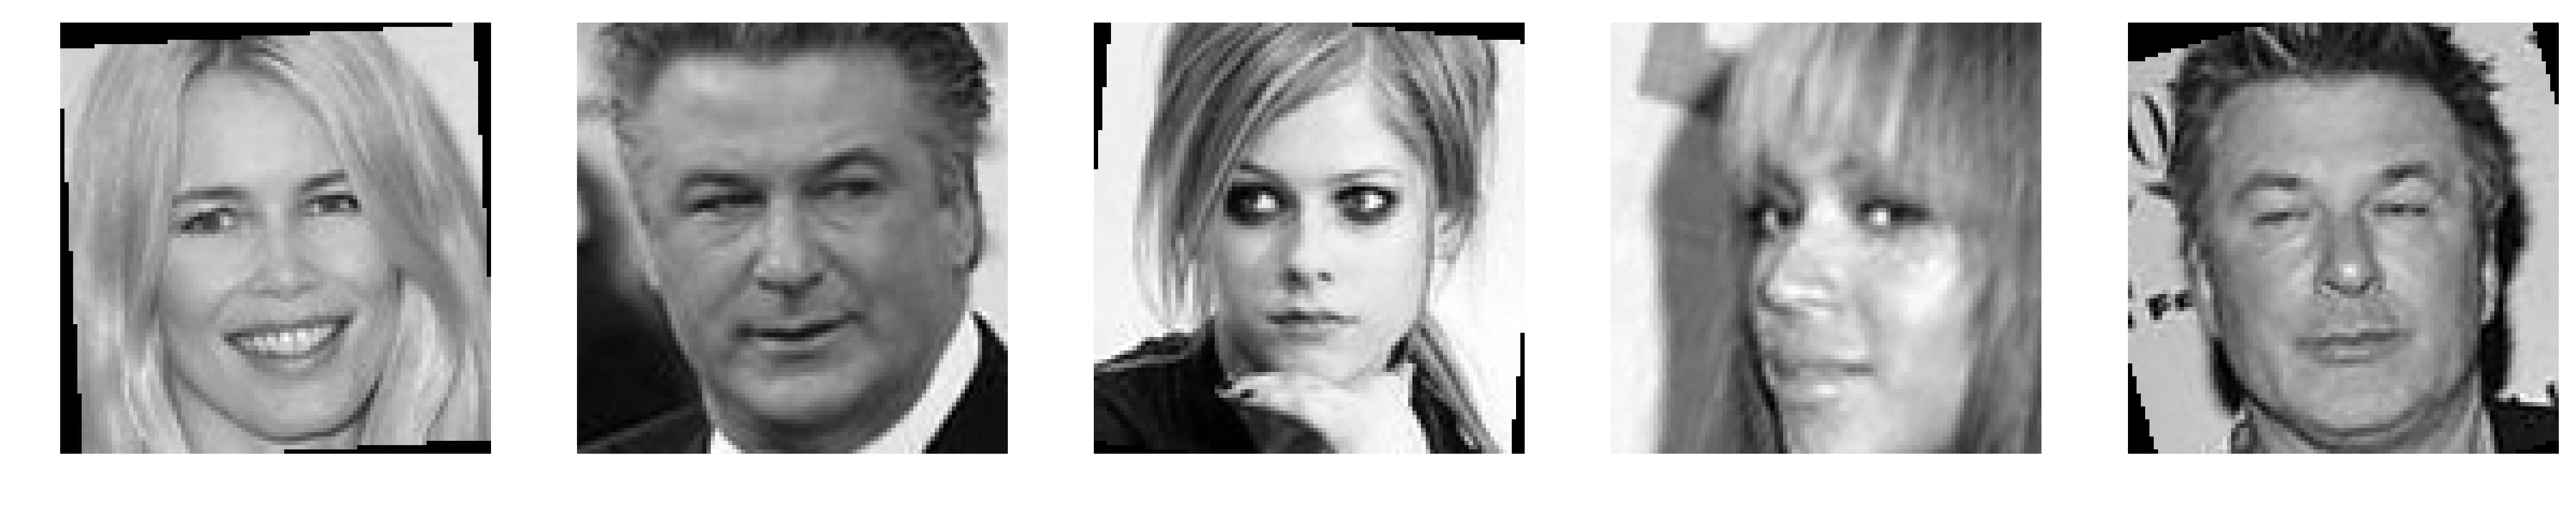

In [17]:

file_list = train_files
im = Image.open(file_list[4]).convert("L")
H,W = np.shape(im)
print('shape: ', (H,W))

arr = image_to_vector(train_files, H,W)
image_grid(arr,H,W,cols=5,rows_count=5)


#### Apply the mean in the images

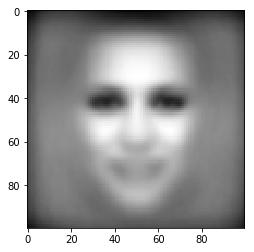

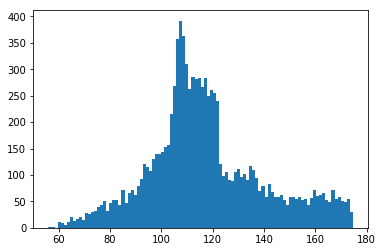

In [18]:
# let's find the mean_image
# mean_image = np.mean(arr, axis=0)
mean_image = extract_mean(arr)

plt.imshow(np.reshape(mean_image,[H,W]), cmap = plt.get_cmap("gray"))
plt.figure()
plt.hist(mean_image,bins=100);

#### Centralize the image

In [19]:
# centering the data (subtract mean face)
# arr_norm = np.zeros([im_number, H*W])
# arr_norm = arr - mean_image
arr_norm = centralize(arr, mean_image, H,W)

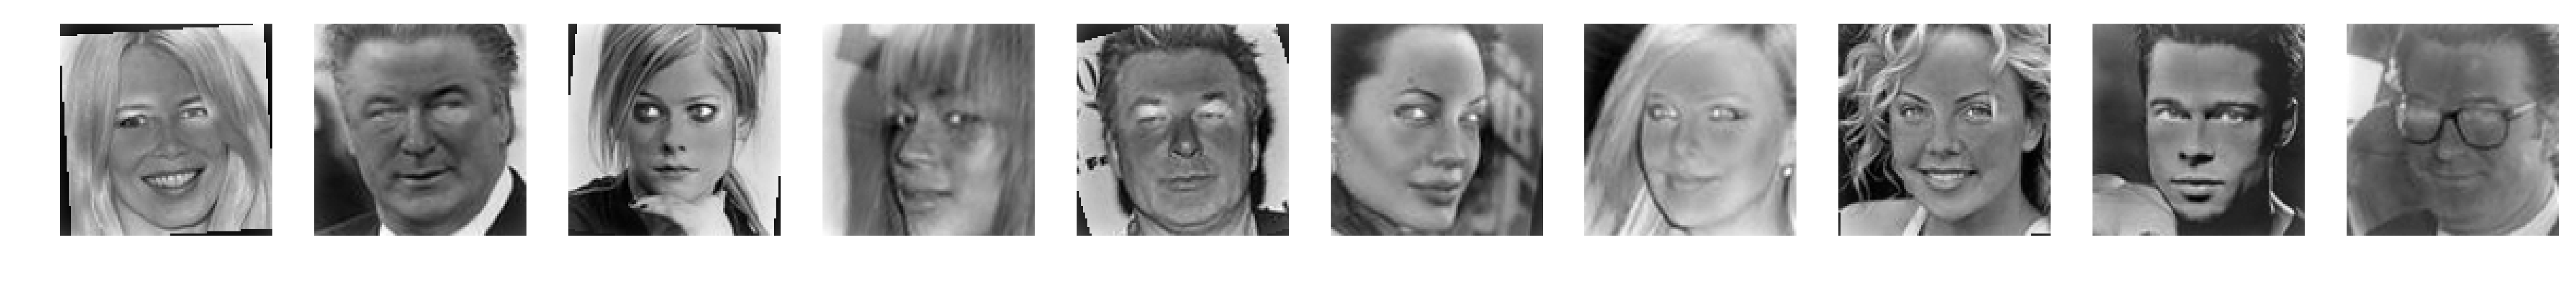

In [20]:
image_grid(arr_norm[:10,:],H,W)

### Train the base model

After some feature engineering, now we can train the model and check the results  .

In [21]:
X_train = base_train_images
y_train = base_train_targets


X_test  = base_test_images
y_test  = base_test_targets


In [23]:
im = Image.open(test_files[0]).convert("L")
H,W = np.shape(im)
print('shape: ', (H,W))

X_test = image_to_vector(test_files,H,W)
mean_test = extract_mean(X_test)
X_test = centralize(X_test, mean_test, H,W)
print(arr_norm.shape)
print(X_test.shape)

X_train_pca, X_test_pca = execute_pca(arr_norm, X_test, n_components=160)
pca = PCA(n_components=160, svd_solver='randomized')
pca.fit(arr_norm)

shape:  (100, 100)
(2245, 10000)
(281, 10000)
Extracting the top 160 eigenfaces from 2245 faces
done in 3.737s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.272s


PCA(copy=True, iterated_power='auto', n_components=160, random_state=None,
  svd_solver='randomized', tol=0.0, whiten=False)

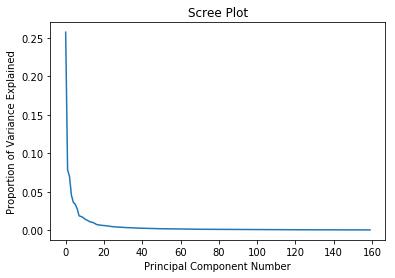

In [24]:
# Let's make a scree plot
pve = pca.explained_variance_ratio_
pve.shape
plt.plot(range(len(pve)), pve)
plt.title("Scree Plot")
plt.ylabel("Proportion of Variance Explained")
plt.xlabel("Principal Component Number")


#### Check the eingenfaces

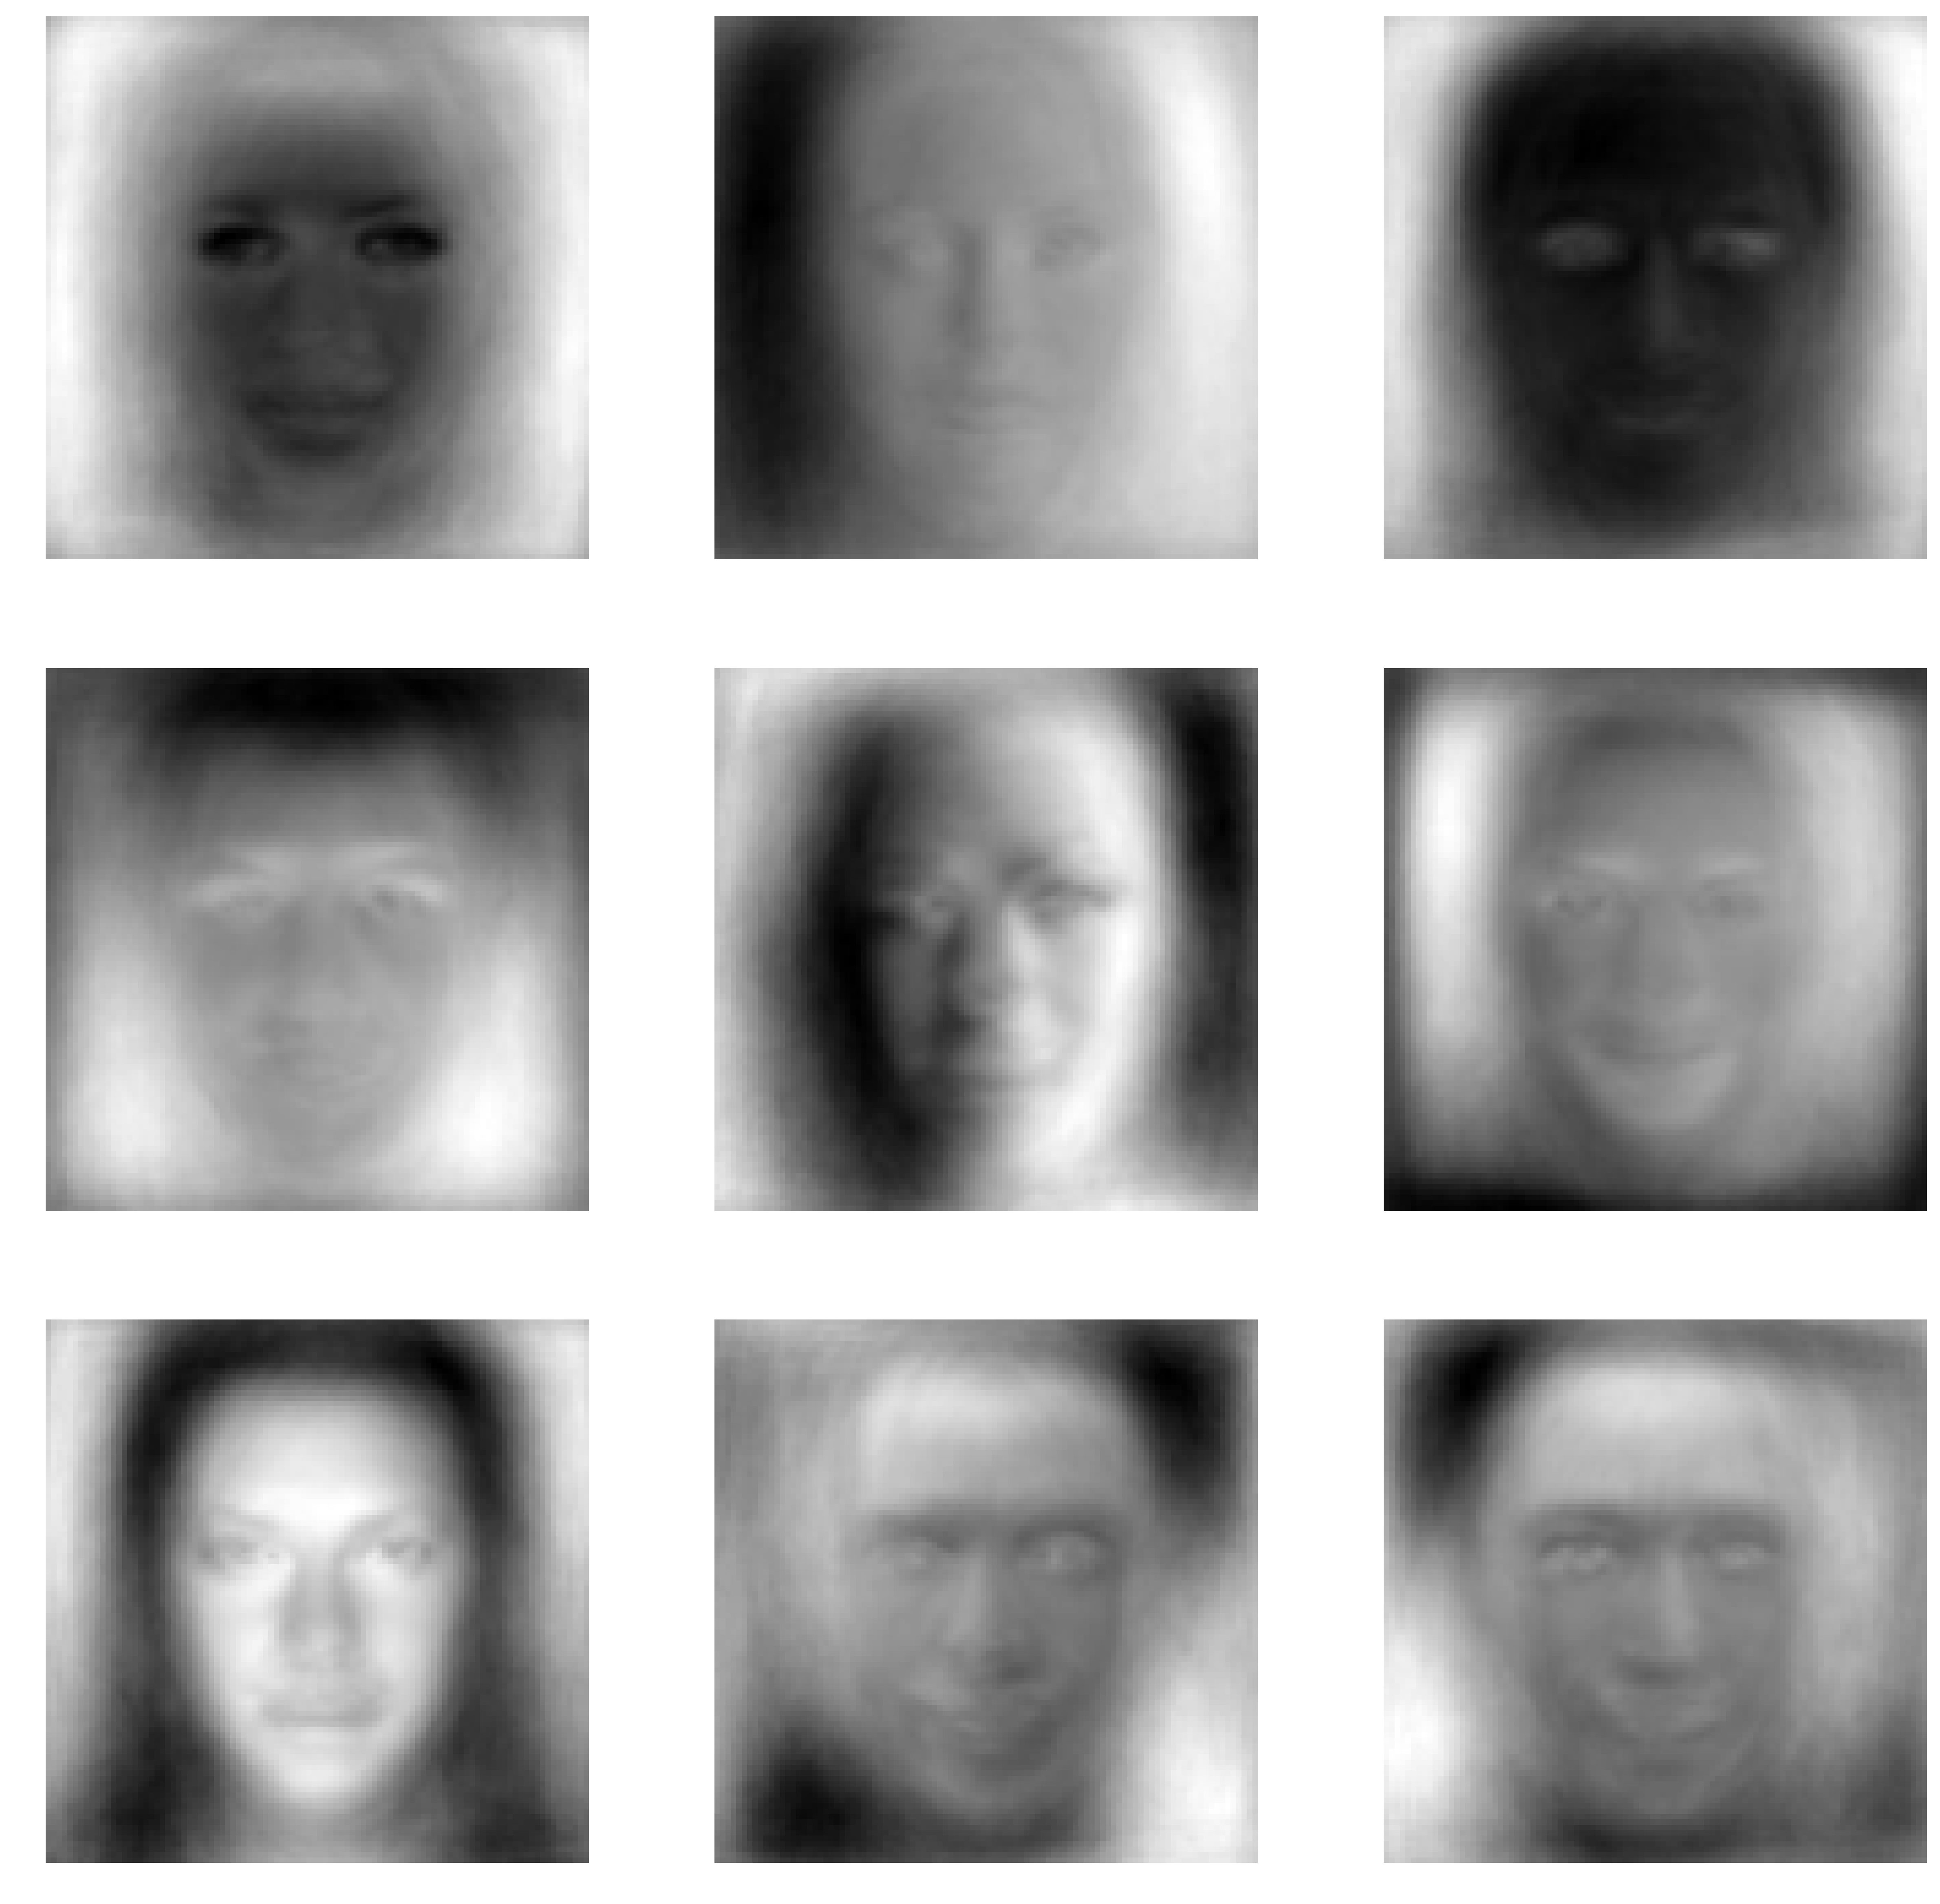

In [25]:
eigenfaces = pca.components_
image_grid(eigenfaces[:9,:], H, W, cols=3)

In [26]:
clf = apply_svm(X_train_pca, y_train)


Fitting the classifier to the training set
Best estimator found by grid search:
SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [28]:
y_pred = clf.predict(X_test_pca)
print(classification_report(y_test, y_pred, target_names=person_names))

print(confusion_matrix(y_test, y_pred, labels=range(len(person_names))))


                   precision    recall  f1-score   support

    /Adam Sandler       0.38      0.55      0.44        11
    /Alec Baldwin       0.44      0.70      0.54        10
  /Angelina Jolie       0.50      0.48      0.49        21
 /Anna Kournikova       0.29      0.35      0.32        17
  /Ashton Kutcher       0.60      0.60      0.60        10
   /Avril Lavigne       0.54      0.50      0.52        30
    /Barack Obama       0.50      0.44      0.47        27
     /Ben Affleck       0.18      0.25      0.21        12
 /Beyonce Knowles       0.78      0.54      0.64        13
       /Brad Pitt       0.58      0.50      0.54        30
    /Cameron Diaz       0.57      0.48      0.52        25
  /Cate Blanchett       0.58      0.44      0.50        16
 /Charlize Theron       0.33      0.40      0.36        20
 /Christina Ricci       0.46      0.43      0.44        14
/Claudia Schiffer       0.29      0.33      0.31        12
      /Clive Owen       0.60      0.46      0.52       

In [29]:
from sklearn.metrics import accuracy_score


In [30]:
accuracy_score(y_test, y_pred)

0.46263345195729538

### Training a haar_cascade model with OpenCV

In [34]:
import cv2
import face_recognition

def get_label(path):
    values = path.split('/')
    if not values:
        return ''
    return values[2]

def trainning_dataset(paths, detect_faces=False):
    recognizer = cv2.face.LBPHFaceRecognizer_create()
    detector= cv2.CascadeClassifier("/usr/share/opencv/haarcascades/haarcascade_frontalface_default.xml");
    images = []
    labels = []
    description_labels = {}
    id = 0
    paths.sort()
    current_label = get_label(paths[0])
    for image_path in tqdm(paths):
        if current_label != get_label(image_path):
            description_labels[id] = current_label
            current_label = get_label(image_path)
            id += 1
        image_pil = Image.open(image_path).convert('L')
        image = np.array(image_pil, 'uint8')
        image = cv2.equalizeHist(image)
        if detect_faces:
            faces = detector.detectMultiScale(image)
            #If a face is there then append that in the list as well as Id of it
            for (x,y,w,h) in faces:
                images.append(image[y:y+h,x:x+w])
                labels.append(id)
        else:
            images.append(image)
            labels.append(id)
                
    recognizer.train(images, np.array(labels))
    recognizer.save('trainning/trainner.yml')
    return recognizer, description_labels 

   
def preprocessing(paths):
    file_list = paths
    im = Image.open(file_list[0]).convert("L")
    H,W = np.shape(im)
    arr = image_to_vector(file_list, H,W)
    mean_image = extract_mean(arr)
    arr_norm = centralize(arr, mean_image, H,W)
    return arr_norm
    #return np.reshape(arr_norm,[H,W])

    
def trainning_with_preprocessing(paths, detect_faces=False):
    recognizer = cv2.face.LBPHFaceRecognizer_create()
    detector= cv2.CascadeClassifier("/usr/share/opencv/haarcascades/haarcascade_frontalface_default.xml");
    images = []
    labels = []
    description_labels = {}
    id = 0
    paths.sort()
    current_label = get_label(paths[0])
    load_images = preprocessing(paths)
    
    for i,image in enumerate(tqdm(load_images)):
        if current_label != get_label(paths[i]):
            description_labels[id] = current_label
            current_label = get_label(paths[i])
            id += 1
        image = np.array(image, 'uint8')
        if detect_faces:
            faces = detector.detectMultiScale(image)
            #If a face is there then append that in the list as well as Id of it
            for (x,y,w,h) in faces:
                images.append(image[y:y+h,x:x+w])
                labels.append(id)
        else:
            images.append(image)
            labels.append(id)

    image_pil = Image.open(paths[0]).convert('L') 
    image_pil = np.array(image, 'uint8')

        
    recognizer.train(images, np.array(labels))
    recognizer.save('trainning/trainner.yml')
    return recognizer, description_labels 
        
        
    

ModuleNotFoundError: No module named 'face_recognition'

  1%|          | 17/2245 [00:00<00:13, 164.68it/s]

tá indo


100%|██████████| 2245/2245 [00:13<00:00, 163.74it/s]


{0: 'Adam Sandler', 1: 'Alec Baldwin', 2: 'Angelina Jolie', 3: 'Anna Kournikova', 4: 'Ashton Kutcher', 5: 'Avril Lavigne', 6: 'Barack Obama', 7: 'Ben Affleck', 8: 'Beyonce Knowles', 9: 'Brad Pitt', 10: 'Cameron Diaz', 11: 'Cate Blanchett', 12: 'Charlize Theron', 13: 'Christina Ricci', 14: 'Claudia Schiffer'}


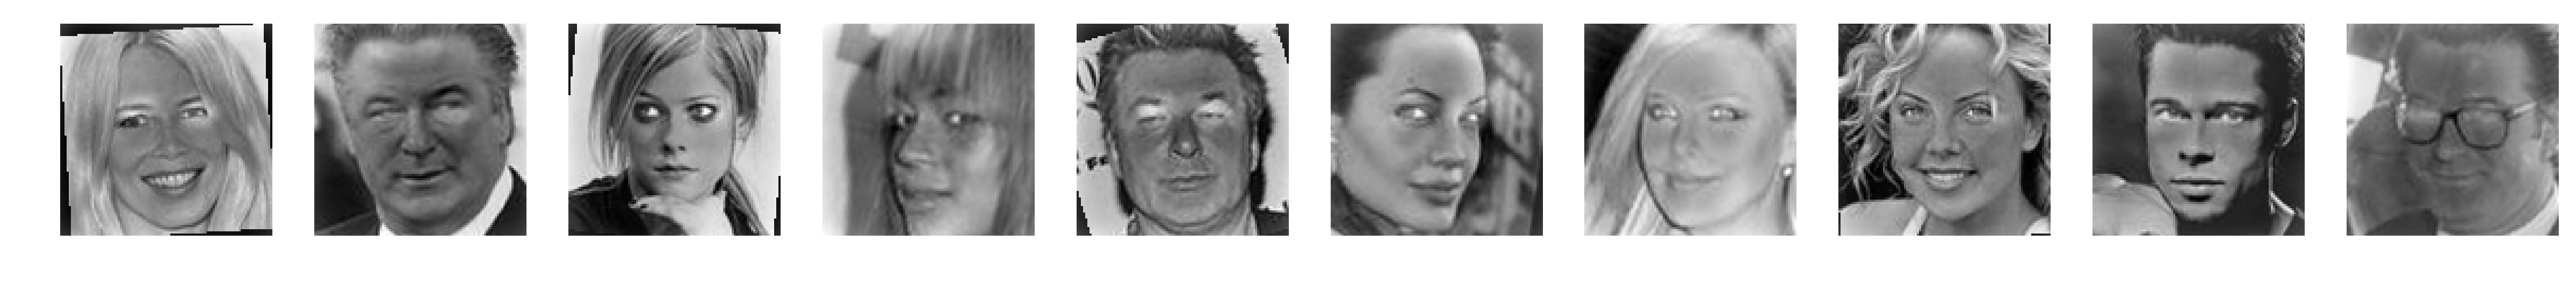

In [29]:
image_pil = preprocessing(train_files)
image_grid(image_pil[:10,:],H,W)


recognizer, labels = trainning_dataset(train_files, True)
print labels

#### Checking accuracy

In [30]:
def check_accuracy(image_paths,labels,recognizer, detect_faces=False):
    detector= cv2.CascadeClassifier("/usr/share/opencv/haarcascades/haarcascade_frontalface_default.xml");
    image_paths.sort()
    accuracy_list = []
    for image_path in image_paths:
#         predict_image_pil  = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        predict_image_pil = Image.open(image_path).convert('L')
        predict_image = np.array(predict_image_pil, np.uint8)
        predict_image = cv2.equalizeHist(predict_image)
        print image_path
        if detect_faces:
            faces = detector.detectMultiScale(predict_image)
            for (x, y, w, h) in faces:
                nbr_predicted, conf = recognizer.predict(predict_image[y: y + h, x: x + w])
                if nbr_predicted not in labels.keys():
                    accuracy_list.append(0)
                    continue
                predicted = labels[nbr_predicted]
                atual = get_label(image_path)
                if atual == predicted:
                    accuracy_list.append(1)
                    print "{} is Correctly Recognized with confidence {}".format(atual, conf)
                else:
                    accuracy_list.append(0)
                    print "{} is Incorrectly Recognized as {}".format(atual, predicted)
        else:
            nbr_predicted, conf = recognizer.predict(predict_image)
            atual = get_label(image_path)
            if nbr_predicted not in labels.keys():
                accuracy_list.append(0)
                continue
                
            predicted = labels[nbr_predicted]
            if atual == predicted:
                accuracy_list.append(1)
                print "{} is Correctly Recognized with confidence {}".format(atual, conf)
            else:
                accuracy_list.append(0)
                print "{} is Incorrectly Recognized as {}".format(atual, predicted)
    
    print "Total: {}".format(len(accuracy_list))
    accuracy_list = np.array(accuracy_list)
    found = np.where(accuracy_list == 1)
    print found
    print "Found: {}".format(len(found[0]))

    accuracy = float(len(found[0])) / len(accuracy_list)
    print "Accuracy is {}".format(accuracy)
    
    

In [31]:

check_accuracy(test_files,labels,recognizer, detect_faces=True )

faces2/test/Adam Sandler/103.jpg
faces2/test/Adam Sandler/132.jpg
Adam Sandler is Incorrectly Recognized as Brad Pitt
faces2/test/Adam Sandler/136.jpg
Adam Sandler is Correctly Recognized with confidence 105.470327437
faces2/test/Adam Sandler/26.jpg
Adam Sandler is Correctly Recognized with confidence 90.8368069765
faces2/test/Adam Sandler/270.jpg
Adam Sandler is Correctly Recognized with confidence 90.318389026
faces2/test/Adam Sandler/33.jpg
Adam Sandler is Correctly Recognized with confidence 105.790623606
faces2/test/Adam Sandler/37.jpg
Adam Sandler is Correctly Recognized with confidence 101.548561209
faces2/test/Adam Sandler/38.jpg
Adam Sandler is Correctly Recognized with confidence 99.6399284944
faces2/test/Adam Sandler/5.jpg
Adam Sandler is Correctly Recognized with confidence 96.8302654409
faces2/test/Adam Sandler/61.jpg
Adam Sandler is Correctly Recognized with confidence 105.177851566
faces2/test/Adam Sandler/80.jpg
Adam Sandler is Correctly Recognized with confidence 87.06

Avril Lavigne is Correctly Recognized with confidence 113.016839873
faces2/test/Avril Lavigne/659.jpg
Avril Lavigne is Correctly Recognized with confidence 109.021137556
faces2/test/Avril Lavigne/661.jpg
Avril Lavigne is Correctly Recognized with confidence 103.487892029
faces2/test/Avril Lavigne/695.jpg
faces2/test/Avril Lavigne/698.jpg
Avril Lavigne is Correctly Recognized with confidence 93.8365991692
faces2/test/Avril Lavigne/702.jpg
Avril Lavigne is Incorrectly Recognized as Cameron Diaz
faces2/test/Avril Lavigne/737.jpg
Avril Lavigne is Correctly Recognized with confidence 109.736573046
faces2/test/Avril Lavigne/75.jpg
Avril Lavigne is Incorrectly Recognized as Angelina Jolie
faces2/test/Barack Obama/100.jpg
Barack Obama is Correctly Recognized with confidence 110.643372549
faces2/test/Barack Obama/103.jpg
Barack Obama is Correctly Recognized with confidence 96.3672921248
faces2/test/Barack Obama/109.jpg
Barack Obama is Correctly Recognized with confidence 107.449245987
faces2/te

Brad Pitt is Correctly Recognized with confidence 125.457241136
faces2/test/Cameron Diaz/103.jpg
Cameron Diaz is Incorrectly Recognized as Anna Kournikova
faces2/test/Cameron Diaz/132.jpg
Cameron Diaz is Correctly Recognized with confidence 115.42562256
faces2/test/Cameron Diaz/138.jpg
faces2/test/Cameron Diaz/142.jpg
Cameron Diaz is Incorrectly Recognized as Claudia Schiffer
faces2/test/Cameron Diaz/160.jpg
Cameron Diaz is Correctly Recognized with confidence 104.777097715
faces2/test/Cameron Diaz/167.jpg
Cameron Diaz is Correctly Recognized with confidence 101.365212837
faces2/test/Cameron Diaz/185.jpg
Cameron Diaz is Correctly Recognized with confidence 100.217852659
faces2/test/Cameron Diaz/203.jpg
Cameron Diaz is Correctly Recognized with confidence 106.518880835
faces2/test/Cameron Diaz/211.jpg
Cameron Diaz is Correctly Recognized with confidence 109.981010387
faces2/test/Cameron Diaz/215.jpg
Cameron Diaz is Correctly Recognized with confidence 94.3898173897
faces2/test/Cameron D

Claudia Schiffer is Correctly Recognized with confidence 111.378234024
faces2/test/Claudia Schiffer/53.jpg
Claudia Schiffer is Correctly Recognized with confidence 103.619147441
faces2/test/Claudia Schiffer/80.jpg
Claudia Schiffer is Incorrectly Recognized as Barack Obama
faces2/test/Clive Owen/100.jpg
faces2/test/Clive Owen/103.jpg
faces2/test/Clive Owen/138.jpg
faces2/test/Clive Owen/142.jpg
faces2/test/Clive Owen/160.jpg
faces2/test/Clive Owen/210.jpg
faces2/test/Clive Owen/211.jpg
faces2/test/Clive Owen/215.jpg
faces2/test/Clive Owen/218.jpg
faces2/test/Clive Owen/255.jpg
faces2/test/Clive Owen/37.jpg
faces2/test/Clive Owen/75.jpg
Clive Owen is Incorrectly Recognized as Cate Blanchett
faces2/test/Clive Owen/91.jpg
Total: 273
(array([  2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  14,  16,
        18,  19,  20,  22,  23,  25,  28,  29,  30,  32,  33,  35,  39,
        41,  42,  43,  44,  45,  46,  47,  50,  51,  52,  53,  64,  66,
        67,  69,  70,  71,  72,  74,  75,  7

### A Deep Learning Model

#### Custom Model

In [5]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD, RMSprop, adam


model = Sequential()

model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu',input_shape=(100,100,3)))
model.add(Conv2D(filters=4, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='softmax'))
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 100, 100, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 4)       1156      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 4)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50, 4)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               1000100   
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
__________

In [40]:
model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

In [41]:
from keras.callbacks import ModelCheckpoint  
### TODO: specify the number of epochs that you would like to use to train the model.
epochs = 10

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.custom.model.hdf5', 
                               verbose=1, save_best_only=True)

trainning_result = model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 2245 samples, validate on 277 samples
Epoch 1/10
2245/2245 [==============================] - 5s - loss: 2.7034 - acc: 0.1301 - val_loss: 2.5551 - val_acc: 0.2527
Epoch 2/10
2245/2245 [==============================] - 5s - loss: 2.4519 - acc: 0.2388 - val_loss: 2.2887 - val_acc: 0.3249
Epoch 3/10
2245/2245 [==============================] - 5s - loss: 2.0600 - acc: 0.3465 - val_loss: 1.9348 - val_acc: 0.4007
Epoch 4/10
2245/2245 [==============================] - 5s - loss: 1.6832 - acc: 0.4797 - val_loss: 1.5399 - val_acc: 0.5343
Epoch 5/10
2245/2245 [==============================] - 5s - loss: 1.3348 - acc: 0.5835 - val_loss: 1.3501 - val_acc: 0.5957
Epoch 6/10
2245/2245 [==============================] - 5s - loss: 1.0752 - acc: 0.6637 - val_loss: 1.3111 - val_acc: 0.6606
Epoch 7/10
2245/2245 [==============================] - 5s - loss: 0.8845 - acc: 0.7163 - val_loss: 1.2211 - val_acc: 0.6498
Epoch 8/10
2245/2245 [==============================] - 5s - loss: 0.7344 - ac

### Visualize the model performance

In [42]:

train_loss = trainning_result.history['loss']
validation_loss = trainning_result.history['val_loss']
train_acc = trainning_result.history['acc']
validation_acc = trainning_result.history['val_acc']
xc = range(epochs)

#### Visualizing Loss

In [56]:
def visualize_loss(xc, train_loss, validation_loss):
    plt.figure(1,figsize=(7,5))
    plt.plot(xc, train_loss)
    plt.plot(xc, validation_loss)
    plt.xlabel('num of epochs')
    plt.ylabel('loss')
    plt.title('Train Loss vs Validation Loss')
    plt.grid(True)
    plt.legend(['train', 'validation'])
    plt.style.use(['ggplot'])
    plt.show()


#### Visualizing Accuracy

In [57]:
def visualize_acc(xc, train_acc, validation_acc):
    plt.figure(1,figsize=(7,5))
    plt.plot(xc, train_acc)
    plt.plot(xc, validation_acc)
    plt.xlabel('num of epochs')
    plt.ylabel('loss')
    plt.title('Train Accuracy vs Validation Accuracy')
    plt.grid(True)
    plt.legend(['train', 'validation'])
    plt.style.use(['ggplot'])
    plt.show()

In [49]:
score = model.evaluate(test_tensors,valid_tensors, verbose=0)

ValueError: Error when checking target: expected dense_6 to have 2 dimensions, but got array with shape (277, 100, 100, 3)

In [50]:
print('Test Loss: ', score[0])
print('Test Accurary: ', score[1])

Test Loss:  1.17820953032
Test Accurary:  0.682310470605


In [18]:
test_image = path_to_tensor('obama.jpeg')
# test_image = cv2.imread('obama.jpeg')
# test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
# test_image = cv2.resize(test_image, (100,100))
# test_image = np.array(test_image)
# test_image = test_image.astype('float32')
# test_image /= 255
# print (test_image.shape)

# test_image = np.expand_dims(test_image, axis=0)
print (test_image.shape)

FileNotFoundError: [Errno 2] No such file or directory: 'obama.jpeg'

In [57]:
print(model.predict_proba(test_image))
print(model.predict_classes(test_image))

1/1 [==============================] - 0s
[[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
1/1 [==============================] - 0s
[6]


#### Visualizing the layers

In [51]:
from keras import backend as K

def get_featuresmaps(model, layer_index, X_batch):
    get_activations = K.function([model.layers[0].input, K.learning_phase()], [model.layers[layer_index].output,])
    activations = get_activations([X_batch, 0])
    return activations

In [63]:
layer_num=1
filter_num=0
activations = get_featuresmaps(model, int(layer_num), test_image)

print(np.shape(activations))
feature_maps = activations[0][0]
print(np.shape(feature_maps))

(1, 1, 100, 100, 32)
(100, 100, 32)


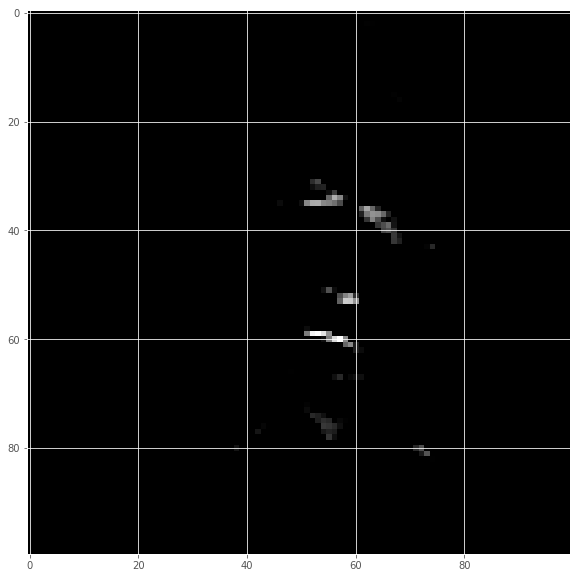

In [64]:
fit = plt.figure(figsize=(10,10))
plt.imshow(feature_maps[:,:, filter_num], cmap='gray')
plt.savefig("featuremaps-layer-{}".format(layer_num)+"-filternum-{}".format(filter_num)+".jpg")

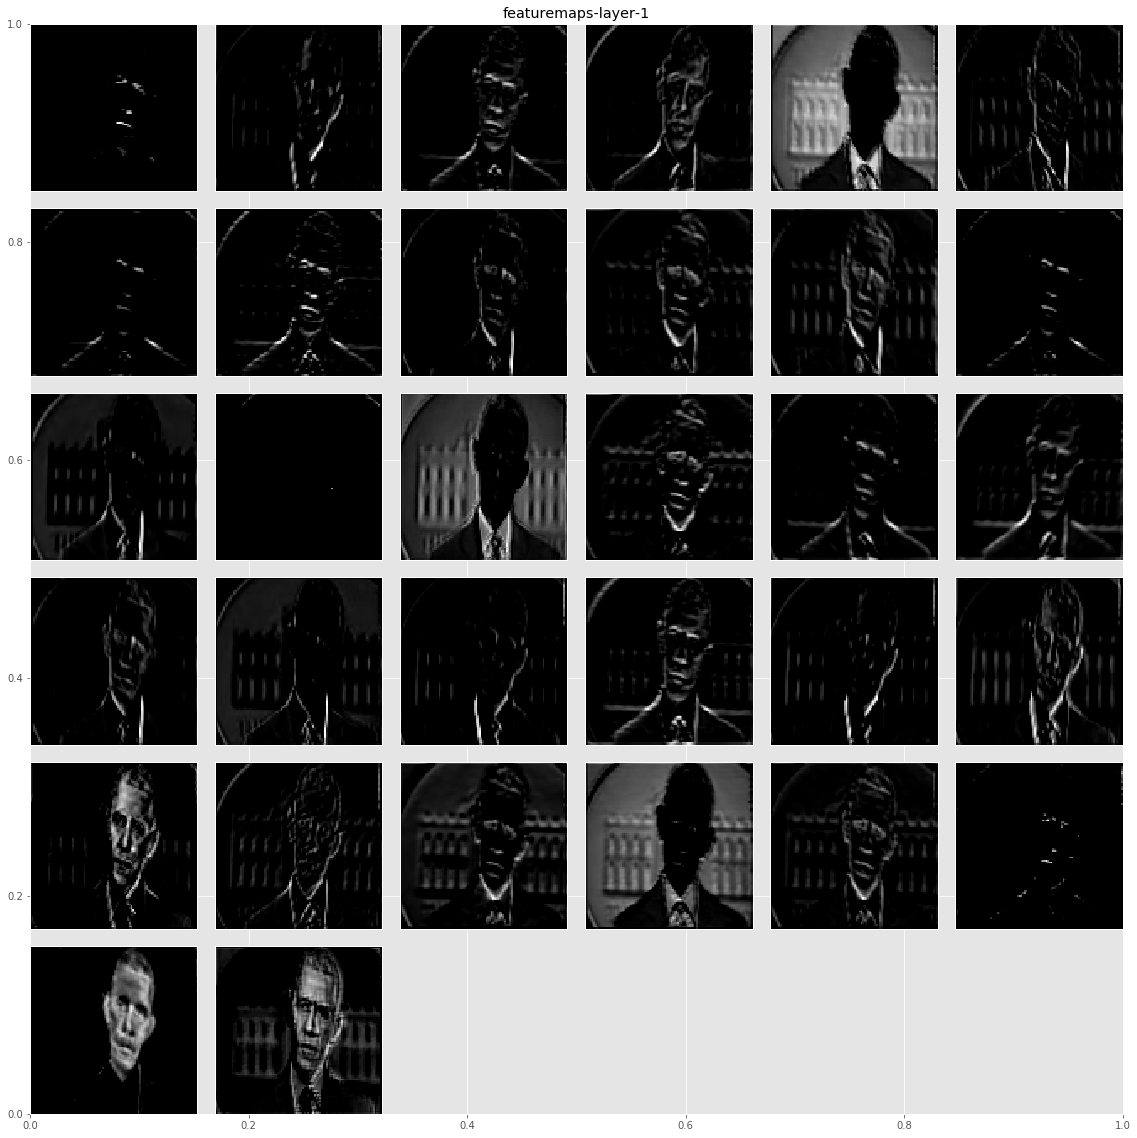

In [65]:
num_of_featuremaps=feature_maps.shape[2]
fig = plt.figure(figsize=(16,16))
plt.title("featuremaps-layer-{}".format(layer_num))
subplot_num=int(np.ceil(np.sqrt(num_of_featuremaps)))
for i in range(int(num_of_featuremaps)):
    ax = fig.add_subplot(subplot_num, subplot_num, i+1)
    ax.imshow(feature_maps[:,:,i], cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
plt.show()
fig.savefig('featuremaps-layer-{}'.format(layer_num)+'.jpg')

#### Confusion Matrix

In [52]:
from sklearn.metrics import classification_report
import itertools

Y_pred = model.predict(valid_tensors)
print(Y_pred)
y_pred = np.argmax(Y_pred, axis=1)
print(y_pred)

[[  4.98707232e-04   8.28700233e-03   5.44234663e-02 ...,   1.29238861e-02
    3.88693586e-02   3.42957093e-04]
 [  2.91049201e-03   2.84446706e-03   6.74415752e-03 ...,   1.74809876e-03
    3.74941975e-02   1.81970024e-03]
 [  1.76364149e-04   1.81593896e-05   4.64334292e-03 ...,   1.21244928e-03
    1.27747480e-03   3.72514805e-05]
 ..., 
 [  1.74878085e-06   1.87315109e-05   6.99220845e-06 ...,   7.14510293e-07
    5.97330185e-08   8.18280969e-03]
 [  4.57529222e-06   5.81327413e-06   4.43312898e-03 ...,   4.06499748e-06
    2.02540052e-03   2.08441088e-06]
 [  1.61949347e-03   1.95096675e-02   2.65223626e-02 ...,   8.51178262e-03
    4.97977575e-03   4.72786184e-03]]
[11 12 10  9  3 10 14  5 10 15  6  4  2  2  6  6  2  6  4  9 11  0  0  5 13
 12  5  4  6  5  9  4  0 10  5  2  5 12  6 14  9  7 11 14 15 10 14  6  3  9
 10 13  2 12  9 10  5  2  2  5 11  1  5  5  4  8  5 11 15  6  4  3  2 14 10
  3  9 11  9 11 12  5  6 11 15 12 11  5 11 11  6  2  2  2  6  1 15  5  6 15
  8  6  9  5  8 

In [53]:
person_names.append('unknown')
print(classification_report(np.argmax(valid_targets, axis=1), y_pred, target_names=person_names))
print(confusion_matrix(np.argmax(valid_targets, axis=1), y_pred))

                   precision    recall  f1-score   support

    /Adam Sandler       1.00      0.64      0.78        11
    /Alec Baldwin       0.83      0.50      0.62        10
  /Angelina Jolie       0.48      0.76      0.59        21
 /Anna Kournikova       1.00      0.71      0.83        17
  /Ashton Kutcher       0.44      0.80      0.57        10
   /Avril Lavigne       0.67      0.87      0.75        30
    /Barack Obama       0.76      0.93      0.83        27
     /Ben Affleck       1.00      0.27      0.43        11
 /Beyonce Knowles       0.78      0.58      0.67        12
       /Brad Pitt       0.70      0.70      0.70        30
    /Cameron Diaz       0.75      0.62      0.68        24
  /Cate Blanchett       0.53      0.62      0.57        16
 /Charlize Theron       0.69      0.58      0.63        19
 /Christina Ricci       0.88      0.50      0.64        14
/Claudia Schiffer       0.60      0.50      0.55        12
      /Clive Owen       0.71      0.77      0.74       

### Transfer Learning

#### VGG16 fine tune

In [6]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D,Dropout, Flatten, Dense



In [7]:
vgg16_model = VGG16(input_tensor=Input(shape=(100,100,3)),include_top=False,weights='imagenet')
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
__________

In [33]:
last_layer = vgg16_model.get_layer('block5_pool').output
custom_layer = Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(last_layer)
custom_layer = Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(custom_layer)
custom_layer = MaxPooling2D(pool_size=(2,2))(custom_layer)
custom_layer = Dropout(0.5)(custom_layer)

custom_layer = Flatten()(custom_layer)
custom_layer = Dense(100, activation='relu')(custom_layer)
output = Dense(16, activation='softmax')(custom_layer)

# custom_layer = Flatten()(last_layer)
# custom_layer = Dense(128, activation='relu')(custom_layer)
# custom_layer = Dense(128, activation='relu')(custom_layer)

# output = Dense(16, activation='softmax')(custom_layer)

custom_vgg16_model = Model(vgg16_model.input, output)
custom_vgg16_model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
__________

In [34]:
for layer in vgg16_model.layers:
    layer.trainable = False

In [35]:
custom_vgg16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [37]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.
epochs = 10

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/custom_vgg16_weights.custom.model.hdf5', 
                               verbose=1, save_best_only=True)

trainning_result = custom_vgg16_model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 2245 samples, validate on 277 samples
Epoch 1/10
2245/2245 [==============================] - 14s - loss: 2.5371 - acc: 0.1840 - val_loss: 2.2502 - val_acc: 0.2816
Epoch 2/10
2245/2245 [==============================] - 12s - loss: 2.1652 - acc: 0.2717 - val_loss: 2.0090 - val_acc: 0.2996
Epoch 3/10
2245/2245 [==============================] - 12s - loss: 1.9295 - acc: 0.3555 - val_loss: 1.8022 - val_acc: 0.4007
Epoch 4/10
2245/2245 [==============================] - 13s - loss: 1.7784 - acc: 0.3880 - val_loss: 1.6848 - val_acc: 0.4404
Epoch 5/10
2245/2245 [==============================] - 12s - loss: 1.6828 - acc: 0.4249 - val_loss: 1.7420 - val_acc: 0.3827
Epoch 6/10
2245/2245 [==============================] - 12s - loss: 1.5590 - acc: 0.4775 - val_loss: 1.6458 - val_acc: 0.4332
Epoch 7/10
2245/2245 [==============================] - 12s - loss: 1.4549 - acc: 0.4967 - val_loss: 1.4800 - val_acc: 0.4765
Epoch 8/10
2245/2245 [==============================] - 12s - loss: 1.3

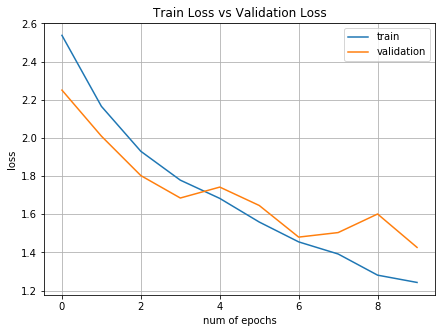

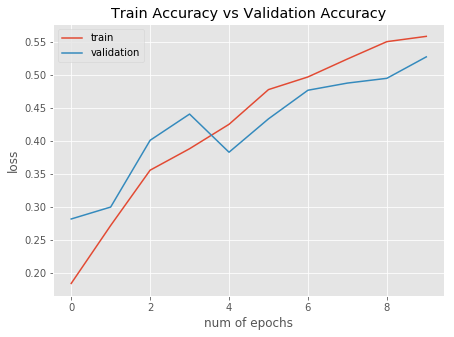

In [38]:
train_loss = trainning_result.history['loss']
validation_loss = trainning_result.history['val_loss']
train_acc = trainning_result.history['acc']
validation_acc = trainning_result.history['val_acc']
xc = range(epochs)

visualize_loss(xc, train_loss, validation_loss)
visualize_acc(xc, train_acc, validation_acc)

#### ResNet50

In [8]:
from keras.applications.resnet50 import ResNet50

# pre-process the data for Keras
train_tensors_224 = paths_to_tensor(train_files,target_size=(224,224)).astype('float32')/255
valid_tensors_224 = paths_to_tensor(valid_files,target_size=(224,224)).astype('float32')/255
test_tensors_224 = paths_to_tensor(test_files,target_size=(224,224)).astype('float32')/255

train_tensors_224 = train_tensors_224.reshape(train_tensors_224.shape[0], 224, 224, 3)
valid_tensors_224 = valid_tensors_224.reshape(valid_tensors_224.shape[0], 224, 224, 3)
test_tensors_224 = test_tensors_224.reshape(test_tensors_224.shape[0], 224, 224, 3)



100%|██████████| 281/281 [00:00<00:00, 1044.79it/s]


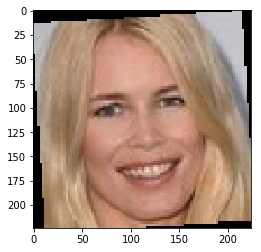

In [22]:
import matplotlib.pyplot as plt                        
img = train_tensors_224[0]
plt.imshow(img,cmap='gray')
plt.show()

In [12]:
resnet_model = ResNet50(input_tensor=Input(shape=(224,224,3)), include_top=False, weights='imagenet')
resnet_model.summary()


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D) (None, 230, 230, 3)   0           input_4[0][0]                    
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 112, 112, 64)  9472        zero_padding2d_3[0][0]           
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 112, 112, 64)  256         conv1[0][0]                      
___________________________________________________________________________________________

In [96]:
from keras.layers import GlobalAveragePooling2D

last_layer = resnet_model.get_layer('avg_pool').output


custom_layer = Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(last_layer)
# custom_layer = Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(custom_layer)
# custom_layer = Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')(custom_layer)

custom_layer = MaxPooling2D(pool_size=(1,1))(custom_layer)
custom_layer = Dropout(0.5)(custom_layer)

custom_layer = Flatten()(custom_layer)
custom_layer = Dense(224, activation='relu')(custom_layer)
out = Dense(16, activation='softmax')(custom_layer)



custom_restnet_model = Model(resnet_model.input, out)
custom_restnet_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D) (None, 230, 230, 3)   0           input_4[0][0]                    
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 112, 112, 64)  9472        zero_padding2d_3[0][0]           
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 112, 112, 64)  256         conv1[0][0]                      
___________________________________________________________________________________________

In [97]:
for layer in custom_restnet_model.layers[:-1]:
    layer.trainable = False

In [98]:
custom_restnet_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.
epochs = 20

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/custom_resnet50_weights.custom.model.hdf5', 
                               verbose=1, save_best_only=True)

trainning_result = custom_restnet_model.fit(train_tensors_224, train_targets, 
          validation_data=(valid_tensors_224, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 2245 samples, validate on 277 samples
Epoch 1/20
2245/2245 [==============================] - 31s - loss: 2.6908 - acc: 0.1265 - val_loss: 2.7070 - val_acc: 0.0975
Epoch 2/20
2245/2245 [==============================] - 31s - loss: 2.6882 - acc: 0.1310 - val_loss: 2.7035 - val_acc: 0.0975
Epoch 3/20
2245/2245 [==============================] - 30s - loss: 2.6899 - acc: 0.1283 - val_loss: 2.7138 - val_acc: 0.1047
Epoch 4/20
 680/2245 [========>.....................] - ETA: 18s - loss: 2.6778 - acc: 0.1353

In [ ]:
import matplotlib.pyplot as plt                        

train_loss = trainning_result.history['loss']
validation_loss = trainning_result.history['val_loss']
train_acc = trainning_result.history['acc']
validation_acc = trainning_result.history['val_acc']
xc = range(epochs)

visualize_loss(xc, train_loss, validation_loss)
visualize_acc(xc, train_acc, validation_acc)
